# Прогнозные модели для увеличения покупательской активности клиентов

Интернет-магазин «XXX» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.
«XXX» — современная компания, поэтому её руководство не хочет принимать решения просто так — только на основе анализа данных и бизнес-моделирования. У компании есть небольшой отдел цифровых технологий, и вам предстоит побыть в роли стажёра в этом отделе.
Итак, вашему отделу поручили разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

**Цель моделей:**

    Нужно промаркировать уровень финансовой активности постоянных покупателей. В компании принято выделять два уровня активности: «снизилась», если клиент стал покупать меньше товаров, и «прежний уровень».
        
    Нужно собрать данные по клиентам по следующим группам:
     
        - Признаки, которые описывают коммуникацию сотрудников компании с клиентом.
        - Признаки, которые описывают продуктовое поведение покупателя. Например, какие товары покупает и как часто.
        - Признаки, которые описывают покупательское поведение клиента. Например, сколько тратил в магазине.
        - Признаки, которые описывают поведение покупателя на сайте. Например, как много страниц просматривает и сколько времени проводит на сайте.

    1. Нужно построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.
    2. В исследование нужно включить дополнительные данные финансового департамента о прибыльности клиента: какой доход каждый покупатель приносил компании за последние три месяца.
    3. Используя данные модели и данные о прибыльности клиентов, нужно выделить сегменты покупателей и разработать для них персонализированные предложения.
    
**Ход исследования:**

    Данные располагаются в четырех файлах '/datasets/market_file.csv', '/datasets/market_money.csv', '/datasets/market_time.csv', '/datasets/money.csv'. Достану их и изучу общую информацию.
    
    Выполню предобработку данных, проверю данные на дубли и пустые значенгия. Приступлю к исследованию. Объединю таблицы.
    
    Выделю целеовй признак, проведу корреляционный анализ и затем приступлю к обучению моделей через пайплайны, с последующим их тестированием и интерпретацией и анализом признаков. Выполню сегментацию покупателей.
    
    Таким образом, мое создание моделей машинного обучения пройдет в семь этапов:
        - Загрузка данных
        - Предобработка данных
        - Исследовательский анализ данных
        - Объединение таблиц
        - Корреляционный анализ
        - Использование пайплайнов
        - Анализ важности признаков
        - Сегментация покупателей

In [1]:
!pip install phik -q

In [2]:
!pip install scikit-learn==1.1.3 -q

In [3]:
!pip install shap -q

In [4]:
# Нужно для того, чтобы shap заработал без ошибки fontsize. Тут бы ядро перезапустить, после команды)
!pip install --upgrade shap matplotlib==3.5.2 -q

## Загрузка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Использует RandomizedSearchCV, чтобы затратить меньше ресурсов и быстрее выбрать модель.
from sklearn.model_selection import RandomizedSearchCV

from sklearn.preprocessing import (
    StandardScaler, 
    OneHotEncoder,
    OrdinalEncoder,
    MinMaxScaler,
    RobustScaler,
    LabelEncoder
)

from sklearn.metrics import roc_auc_score
import shap

In [2]:
market_file_data = pd.read_csv('/datasets/market_file.csv', decimal = ',')

In [3]:
market_file_data.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.0,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [4]:
market_file_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   id                                   1300 non-null   int64 
 1   Покупательская активность            1300 non-null   object
 2   Тип сервиса                          1300 non-null   object
 3   Разрешить сообщать                   1300 non-null   object
 4   Маркет_актив_6_мес                   1300 non-null   object
 5   Маркет_актив_тек_мес                 1300 non-null   int64 
 6   Длительность                         1300 non-null   int64 
 7   Акционные_покупки                    1300 non-null   object
 8   Популярная_категория                 1300 non-null   object
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64 
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64 
 11  Ошибка_сервиса                       1300 n

In [5]:
market_money_data = pd.read_csv('/datasets/market_money.csv')

In [6]:
market_money_data.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [7]:
market_money_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [8]:
market_time_data = pd.read_csv('/datasets/market_time.csv', decimal = ',')

In [9]:
market_time_data.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [10]:
market_time_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [11]:
money_data = pd.read_csv('/datasets/money.csv', sep=';', decimal = ',')

In [12]:
money_data.head()

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


In [13]:
money_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


**Вывод:**

    - Были выгружены данные из четырех разных файлов в четыре переменные. Все данные соответствуют описанию.
    - В таблице market_file_data 1300 записи с колонками, совпадающими с описанием.
    - В таблице market_money_data 3900 записи с колонками идентификатора, Период и Выручка.
    - В таблице market_time_data 2600 записей с колонками id, Период, минут.
    - В таблице money_data 1300 записей с колонками id и Прибыль.

## Предобработка данных

In [14]:
market_file_data.columns

Index(['id', 'Покупательская активность', 'Тип сервиса', 'Разрешить сообщать',
       'Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность',
       'Акционные_покупки', 'Популярная_категория',
       'Средний_просмотр_категорий_за_визит',
       'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса',
       'Страниц_за_визит'],
      dtype='object')

In [15]:
new_columns = []
for column in market_file_data.columns:
    new_columns.append(column.replace(' ', '_').lower())
    
market_file_data.columns = new_columns
market_file_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   id                                   1300 non-null   int64 
 1   покупательская_активность            1300 non-null   object
 2   тип_сервиса                          1300 non-null   object
 3   разрешить_сообщать                   1300 non-null   object
 4   маркет_актив_6_мес                   1300 non-null   object
 5   маркет_актив_тек_мес                 1300 non-null   int64 
 6   длительность                         1300 non-null   int64 
 7   акционные_покупки                    1300 non-null   object
 8   популярная_категория                 1300 non-null   object
 9   средний_просмотр_категорий_за_визит  1300 non-null   int64 
 10  неоплаченные_продукты_штук_квартал   1300 non-null   int64 
 11  ошибка_сервиса                       1300 n

In [16]:
market_file_data.head(5)

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.0,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [17]:
for column in ['маркет_актив_6_мес', 'акционные_покупки']:
    market_file_data[column] = market_file_data[column].astype(float)

In [18]:
market_file_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   покупательская_активность            1300 non-null   object 
 2   тип_сервиса                          1300 non-null   object 
 3   разрешить_сообщать                   1300 non-null   object 
 4   маркет_актив_6_мес                   1300 non-null   float64
 5   маркет_актив_тек_мес                 1300 non-null   int64  
 6   длительность                         1300 non-null   int64  
 7   акционные_покупки                    1300 non-null   float64
 8   популярная_категория                 1300 non-null   object 
 9   средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  ошибка_сервиса                

In [19]:
market_file_data.isna().sum()

id                                     0
покупательская_активность              0
тип_сервиса                            0
разрешить_сообщать                     0
маркет_актив_6_мес                     0
маркет_актив_тек_мес                   0
длительность                           0
акционные_покупки                      0
популярная_категория                   0
средний_просмотр_категорий_за_визит    0
неоплаченные_продукты_штук_квартал     0
ошибка_сервиса                         0
страниц_за_визит                       0
dtype: int64

In [20]:
market_file_data.duplicated().sum()

0

In [21]:
market_file_data.nunique()

id                                     1300
покупательская_активность                 2
тип_сервиса                               3
разрешить_сообщать                        2
маркет_актив_6_мес                       41
маркет_актив_тек_мес                      3
длительность                            658
акционные_покупки                        42
популярная_категория                      6
средний_просмотр_категорий_за_визит       6
неоплаченные_продукты_штук_квартал       11
ошибка_сервиса                           10
страниц_за_визит                         20
dtype: int64

In [22]:
for cat_columns in [
    'покупательская_активность', 
    'тип_сервиса', 
    'разрешить_сообщать', 
    'маркет_актив_6_мес',
    'маркет_актив_тек_мес', 
    'популярная_категория',
    'акционные_покупки',
    'неоплаченные_продукты_штук_квартал',
    'средний_просмотр_категорий_за_визит',
    'ошибка_сервиса',
    'страниц_за_визит'
]:
    print(cat_columns+':', market_file_data[cat_columns].sort_values().unique())

покупательская_активность: ['Прежний уровень' 'Снизилась']
тип_сервиса: ['премиум' 'стандарт' 'стандартт']
разрешить_сообщать: ['да' 'нет']
маркет_актив_6_мес: [0.9 1.4 1.5 1.7 2.4 2.6 2.7 2.9 3.  3.1 3.2 3.3 3.4 3.5 3.6 3.7 3.8 3.9
 4.  4.1 4.2 4.3 4.4 4.5 4.6 4.7 4.8 4.9 5.  5.1 5.2 5.3 5.4 5.5 5.6 5.7
 5.8 5.9 6.1 6.3 6.6]
маркет_актив_тек_мес: [3 4 5]
популярная_категория: ['Домашний текстиль' 'Косметика и аксесуары' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника' 'Техника для красоты и здоровья'
 'Товары для детей']
акционные_покупки: [0.   0.11 0.12 0.13 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23
 0.24 0.25 0.26 0.27 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.39
 0.4  0.44 0.47 0.6  0.74 0.75 0.89 0.9  0.91 0.93 0.94 0.95 0.98 0.99]
неоплаченные_продукты_штук_квартал: [ 0  1  2  3  4  5  6  7  8  9 10]
средний_просмотр_категорий_за_визит: [1 2 3 4 5 6]
ошибка_сервиса: [0 1 2 3 4 5 6 7 8 9]
страниц_за_визит: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 

In [23]:
market_file_data['тип_сервиса'] = market_file_data['тип_сервиса'].replace(['стандартт'], 'стандарт')

In [24]:
market_money_data.columns

Index(['id', 'Период', 'Выручка'], dtype='object')

In [25]:
market_money_data.columns = market_money_data.columns.str.lower()
market_money_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   период   3900 non-null   object 
 2   выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [26]:
market_money_data.isna().sum()

id         0
период     0
выручка    0
dtype: int64

In [27]:
market_money_data.duplicated().sum()

0

In [28]:
market_money_data.nunique()

id         1300
период        3
выручка    2776
dtype: int64

In [29]:
market_money_data['период'].unique()

array(['препредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц'],
      dtype=object)

In [30]:
market_time_data.columns

Index(['id', 'Период', 'минут'], dtype='object')

In [31]:
market_time_data.columns = market_time_data.columns.str.lower()
market_time_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [32]:
market_time_data.isna().sum()

id        0
период    0
минут     0
dtype: int64

In [33]:
market_time_data.duplicated().sum()

0

In [34]:
market_time_data.nunique()

id        1300
период       2
минут       20
dtype: int64

In [35]:
market_time_data['период'].unique()

array(['текущий_месяц', 'предыдцщий_месяц'], dtype=object)

In [36]:
market_time_data['период'] = market_time_data['период'].replace(['предыдцщий_месяц'], 'предыдущий_месяц')

In [37]:
market_time_data['минут'].sort_values().unique()

array([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
       21, 22, 23])

In [38]:
money_data.columns

Index(['id', 'Прибыль'], dtype='object')

In [39]:
money_data.columns = money_data.columns.str.lower()
money_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


In [40]:
money_data.isna().sum()

id         0
прибыль    0
dtype: int64

In [41]:
money_data.duplicated().sum()

0

In [42]:
money_data.nunique()

id         1300
прибыль     400
dtype: int64

**Вывод:**

    - Поля были нормализованы к snake case и к нижнему регистру.
    - Удалены неявные дубликаты 'стандарт' из таблицы market_file_data поля 'тип_сервиса'.
    - Переименованы значения в таблице market_time_data, поля 'период' с 'предыдцщий_месяц', на 'предыдущий_месяц'. Острой необходимости не было, но так лучше читается.
    - Также были преобразованы колонки 'маркет_актив_6_мес', 'акционные_покупки' таблицы market_file_data из типа object в float64.

## Исследовательский анализ данных

In [43]:
market_file_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   покупательская_активность            1300 non-null   object 
 2   тип_сервиса                          1300 non-null   object 
 3   разрешить_сообщать                   1300 non-null   object 
 4   маркет_актив_6_мес                   1300 non-null   float64
 5   маркет_актив_тек_мес                 1300 non-null   int64  
 6   длительность                         1300 non-null   int64  
 7   акционные_покупки                    1300 non-null   float64
 8   популярная_категория                 1300 non-null   object 
 9   средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  ошибка_сервиса                

In [44]:
market_file_data.head(5)

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [45]:
def pivot_pie(title, table, index, values, funcs):
    pivot = table.pivot_table(index=index, values=values, aggfunc=funcs)
    
    if funcs[0] == 'count':
        total = pivot[funcs[0]].sum()
        pivot['Количество'] = pivot[funcs[0]] / total
        pivot['Количество'].plot(kind='pie', autopct='%.1f%%', figsize=(10, 7), startangle=90)
    else:
        pivot.columns = funcs
        for f in funcs:
            pivot[f].plot(kind='pie', autopct='%.1f%%', figsize=(10, 7), startangle=90)
            plt.title(title)
            plt.legend()
            plt.show()

In [46]:
def pivot_bar(title, ylabel, xlabel, table, index, values, funcs):
    pivot = table.pivot_table(index=index, values=values, aggfunc=funcs).sort_values(by=index)
    
    if funcs[0] == 'count':
        pivot.plot(kind='bar', y='count', figsize=(15, 7), grid=True)
    else:
        pivot.columns = funcs
        for f in funcs:
            pivot.plot(kind='bar', y=f, figsize=(15, 7), grid=True)
    plt.title(title)
    plt.legend()
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.show()

**Проверим долю покупательской активности:**

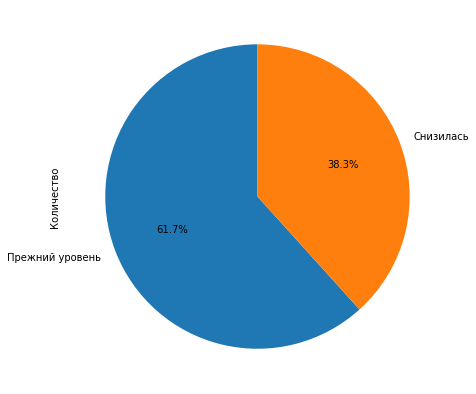

In [47]:
pivot_pie('покупательская активность', market_file_data, 'покупательская_активность', 'id', ['count'])

У 38.3% пользователей от общего числа наблюдается снижение активности.

**Проверим сколько премиальных пользователей имеет магазин:**

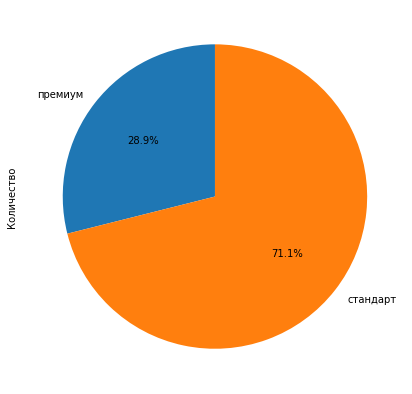

In [48]:
pivot_pie('тип сервиса', market_file_data, 'тип_сервиса', 'id', ['count'])

У магазина в основном пользователи типа стандарт

**Проверим согласие дополнительных товаров пользователей:**

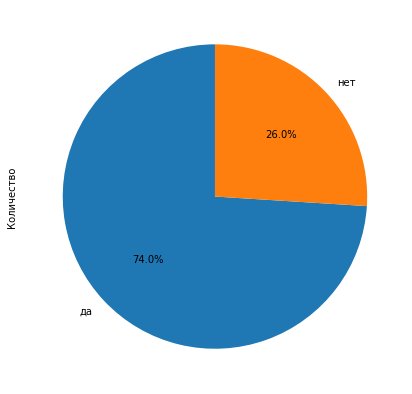

In [49]:
pivot_pie('разрешить сообщать', market_file_data, 'разрешить_сообщать', 'id', ['count'])

Большинство пользователей дали согласие, тем не менее 26% не готовы принимать дополнительную рассылку.

**Проверим популярные категории товаров:**

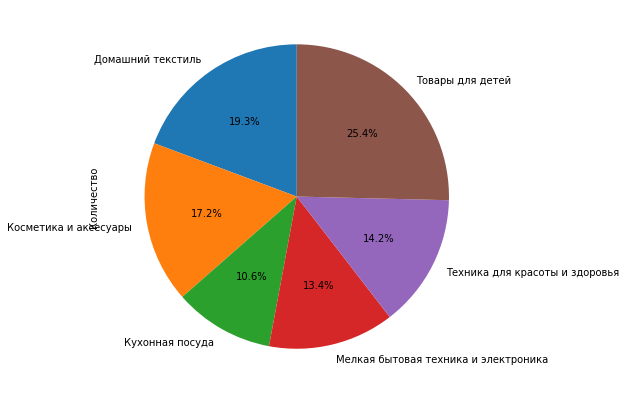

In [50]:
pivot_pie('популярная категория', market_file_data, 'популярная_категория', 'id', ['count'])

Самой востребованной категорией среди пользователей является "Товары для детей", далее "Домашний текстиль" и замыкает тройку "Косметика и аксесуары". Тем не менее, остальные категории тоже занимают хорошую долю от всех покупателей.

**Проверим зависимость активности пользователя на сайте от длительности его регистрации:**

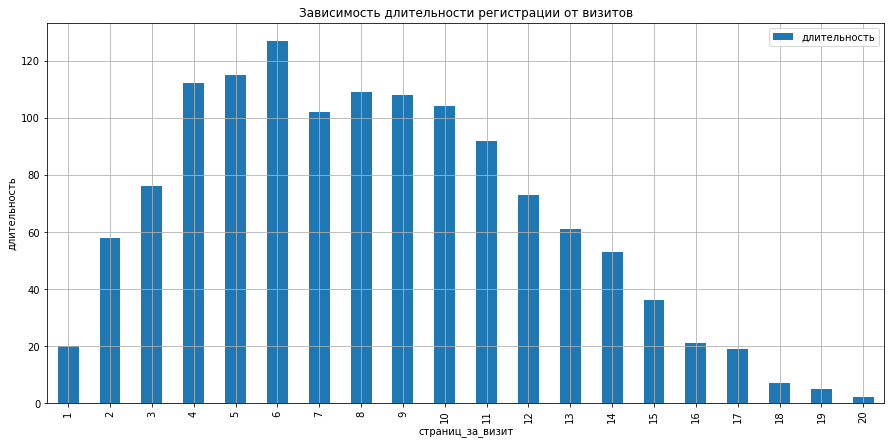

In [51]:
pivot_bar('Зависимость длительности регистрации от визитов', 'длительность', 'страниц_за_визит', market_file_data, 'страниц_за_визит', 'длительность', ['count'])

Можем заметить, что новые пользователи самые активные. Вероятно это связано с тем, что постоянные покупатели заходят за уже за конкретными товарами и знают что они хотят.

**Проверим все количественные графики, с целью выявить аномалии:**

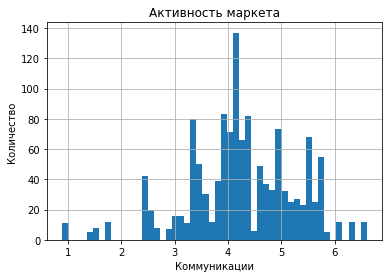

In [52]:
plt.hist(market_file_data['маркет_актив_6_мес'], bins=50)
plt.grid(True)
plt.title('Активность маркета')
plt.xlabel('Коммуникации')
plt.ylabel('Количество')
plt.show()

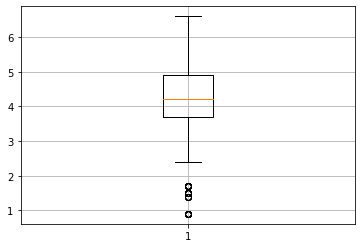

In [53]:
plt.boxplot(market_file_data['маркет_актив_6_мес'])
plt.grid(True)

У признака 'маркет_актив_6_мес' имеются выбросы по обе стороны. Добавим дополнительный признак, на случай, если придется избавиться от этого из-за выбросов.

In [54]:
market_file_data['маркет_актив_6_мес'].sort_values().unique()

array([0.9, 1.4, 1.5, 1.7, 2.4, 2.6, 2.7, 2.9, 3. , 3.1, 3.2, 3.3, 3.4,
       3.5, 3.6, 3.7, 3.8, 3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7,
       4.8, 4.9, 5. , 5.1, 5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6.1,
       6.3, 6.6])

In [55]:
market_file_data['маркет_актив_6_мес_оценка'] = market_file_data['маркет_актив_6_мес'].apply(lambda x : 'низкий' if x < 2 else 'средний' if x <= 6 else 'высокий')

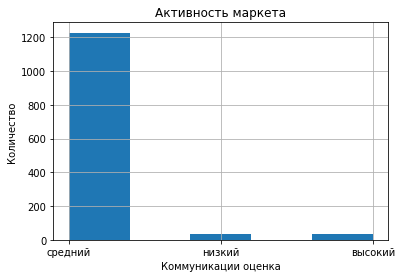

In [56]:
plt.hist(market_file_data['маркет_актив_6_мес_оценка'], bins=5)
plt.grid(True)
plt.title('Активность маркета')
plt.xlabel('Коммуникации оценка')
plt.ylabel('Количество')
plt.show()

У этого признака получился дисбаланс классов - следует это учесть в будущих моделях.

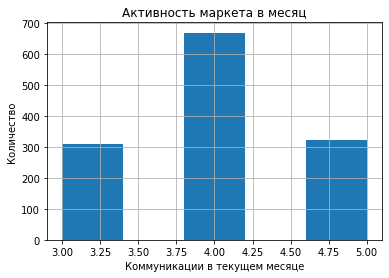

In [57]:
plt.hist(market_file_data['маркет_актив_тек_мес'], bins=5)
plt.grid(True)
plt.title('Активность маркета в месяц')
plt.xlabel('Коммуникации в текущем месяце')
plt.ylabel('Количество')
plt.show()

In [58]:
market_file_data['маркет_актив_тек_мес'].unique()

array([5, 4, 3])

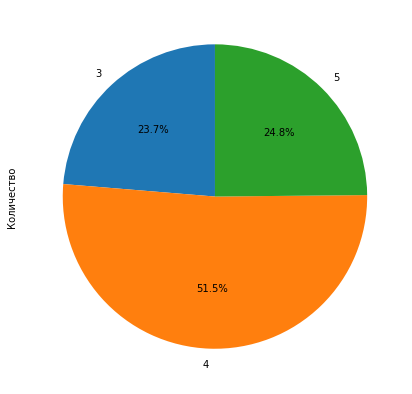

In [59]:
pivot_pie('Активность маркета в месяц', market_file_data, 'маркет_актив_тек_мес', 'id', ['count'])

У коммуникаций в текущем месяце, также дисбаланс классов - учтем в будущих моделях.

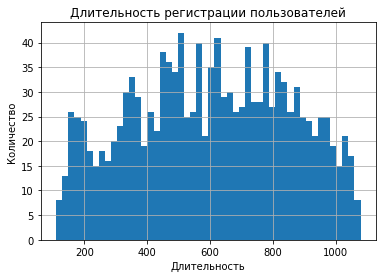

In [60]:
plt.hist(market_file_data['длительность'], bins=50)
plt.grid(True)
plt.title('Длительность регистрации пользователей')
plt.xlabel('Длительность')
plt.ylabel('Количество')
plt.show()

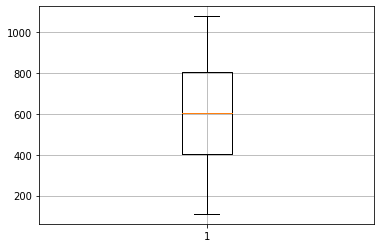

In [61]:
plt.boxplot(market_file_data['длительность'])
plt.grid(True)

По длительности регистрации пользователей можно сказать, что выбросов нет, аномалий не найдено.

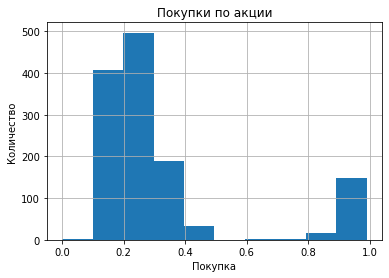

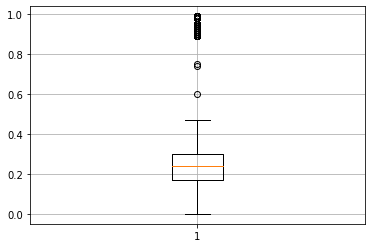

In [62]:
plt.hist(market_file_data['акционные_покупки'], bins=10)
plt.grid(True)
plt.title('Покупки по акции')
plt.xlabel('Покупка')
plt.ylabel('Количество')
plt.show()

plt.boxplot(market_file_data['акционные_покупки'])
plt.grid(True)

У покупок по акции также можно выделить категориальный признак, в районе 0.6.

In [63]:
market_file_data['акционные_покупки_оценка'] = market_file_data['акционные_покупки'].apply(lambda x : 'редкие' if x < 0.6 else 'частые')

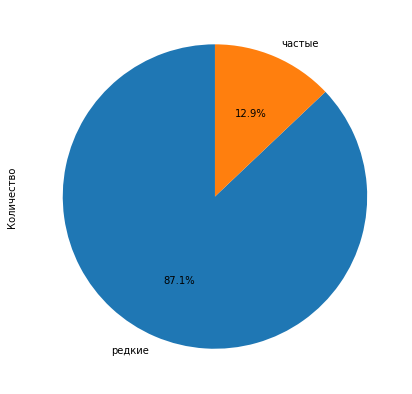

In [64]:
pivot_pie('Покупки по акции', market_file_data, 'акционные_покупки_оценка', 'id', ['count'])

Опять можем наблюдать дисбаланс, который нужно будет учесть

In [65]:
market_file_data.head(5)

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,маркет_актив_6_мес_оценка,акционные_покупки_оценка
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5,средний,редкие
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,средний,частые
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,средний,редкие
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,средний,частые
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,средний,частые


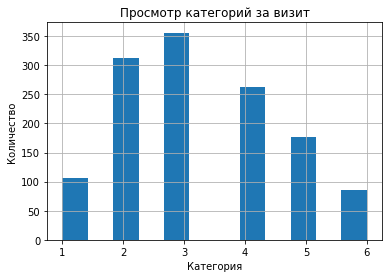

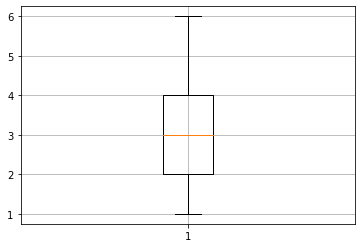

In [66]:
plt.hist(market_file_data['средний_просмотр_категорий_за_визит'], bins=12)
plt.grid(True)
plt.title('Просмотр категорий за визит')
plt.xlabel('Категория')
plt.ylabel('Количество')
plt.show()

plt.boxplot(market_file_data['средний_просмотр_категорий_за_визит'])
plt.grid(True)

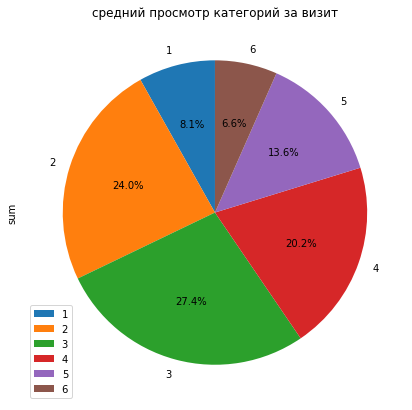

In [67]:
pivot_pie('средний просмотр категорий за визит', market_file_data, 'средний_просмотр_категорий_за_визит', 'id', ['sum'])

Средний просмотр категорий в норме.

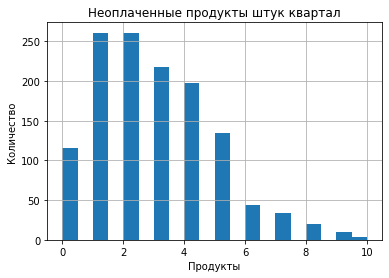

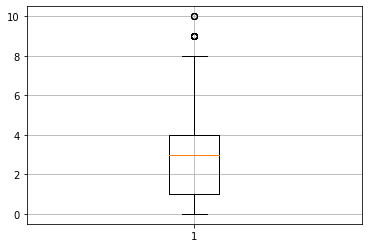

In [68]:
plt.hist(market_file_data['неоплаченные_продукты_штук_квартал'], bins=20)
plt.grid(True)
plt.title('Неоплаченные продукты штук квартал')
plt.xlabel('Продукты')
plt.ylabel('Количество')
plt.show()

plt.boxplot(market_file_data['неоплаченные_продукты_штук_квартал'])
plt.grid(True)

Наблюдаем выбросы в неоплаченных продуктах. Можно тоже добавить категориальный признак.

In [69]:
market_file_data['неоплаченные_продукты_штук_квартал_оценка'] = market_file_data['неоплаченные_продукты_штук_квартал'].apply(lambda x : 'низкие' if x < 3 else 'нормальные' if x < 6 else 'высокий')

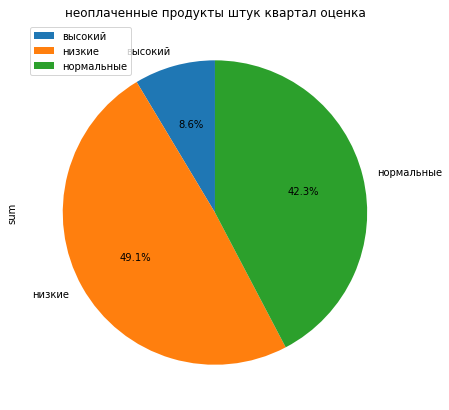

In [70]:
pivot_pie('неоплаченные продукты штук квартал оценка', market_file_data, 'неоплаченные_продукты_штук_квартал_оценка', 'id', ['sum'])

Наблюдаем дисбаланс между высоким признаком и остальными. Учтем в будущих моделях.

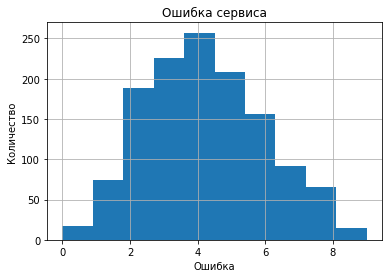

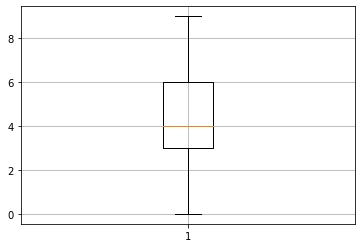

In [71]:
plt.hist(market_file_data['ошибка_сервиса'], bins=10)
plt.grid(True)
plt.title('Ошибка сервиса')
plt.xlabel('Ошибка')
plt.ylabel('Количество')
plt.show()

plt.boxplot(market_file_data['ошибка_сервиса'])
plt.grid(True)

Выбросов у ошибок сервиса не найдено.

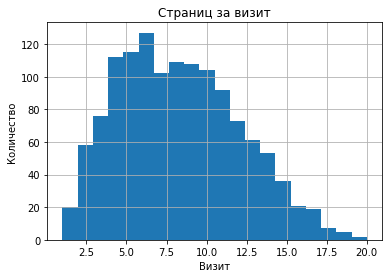

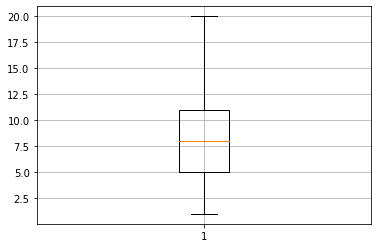

In [72]:
plt.hist(market_file_data['страниц_за_визит'], bins=20)
plt.grid(True)
plt.title('Страниц за визит')
plt.xlabel('Визит')
plt.ylabel('Количество')
plt.show()

plt.boxplot(market_file_data['страниц_за_визит'])
plt.grid(True)

В страницах за визит также не найдено выбросов.

**Далее проанализируем таблицу market_money_data:**

In [73]:
market_money_data.head(5)

,id,период,выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


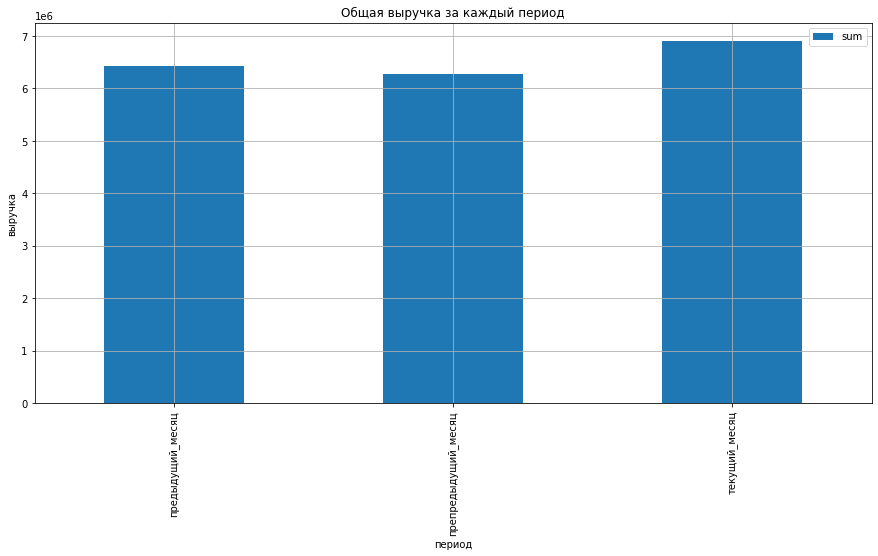

In [74]:
pivot_bar('Общая выручка за каждый период', 'выручка', 'период', market_money_data, 'период', 'выручка', ['sum'])

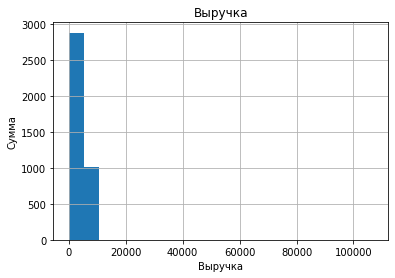

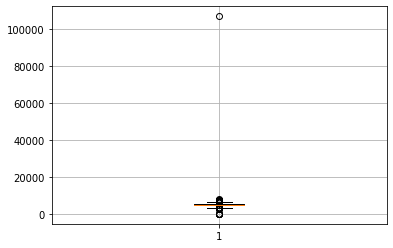

In [75]:
plt.hist(market_money_data['выручка'], bins=20)
plt.grid(True)
plt.title('Выручка')
plt.xlabel('Выручка')
plt.ylabel('Сумма')
plt.show()

plt.boxplot(market_money_data['выручка'])
plt.grid(True)

In [76]:
market_money_data['выручка'].describe()

count      3900.000000
mean       5025.696051
std        1777.704104
min           0.000000
25%        4590.150000
50%        4957.500000
75%        5363.000000
max      106862.200000
Name: выручка, dtype: float64

In [77]:
market_money_data[market_money_data['выручка'] > 10000]

,id,период,выручка
98,215380,текущий_месяц,106862.2


In [78]:
market_money_data = market_money_data.drop(index=98)

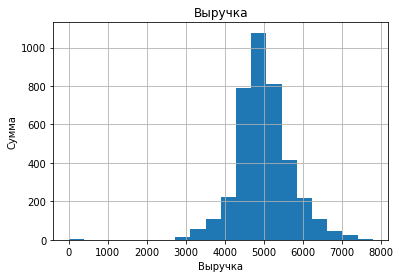

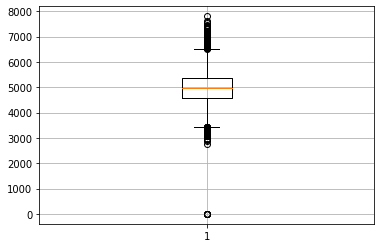

In [79]:
plt.hist(market_money_data['выручка'], bins=20)
plt.grid(True)
plt.title('Выручка')
plt.xlabel('Выручка')
plt.ylabel('Сумма')
plt.show()

plt.boxplot(market_money_data['выручка'])
plt.grid(True)

Выбросы остались, но их количество и природа объяснимы. Например пользователь мог не сделать ни одной покупки и мы имеем значение 0 или активный пользователь выдает показатель около 8000.

**Далее проанализируем таблицу market_time_data:**

In [80]:
market_time_data.head(5)

,id,период,минут
0,215348,текущий_месяц,14
1,215348,предыдущий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдущий_месяц,12
4,215350,текущий_месяц,13


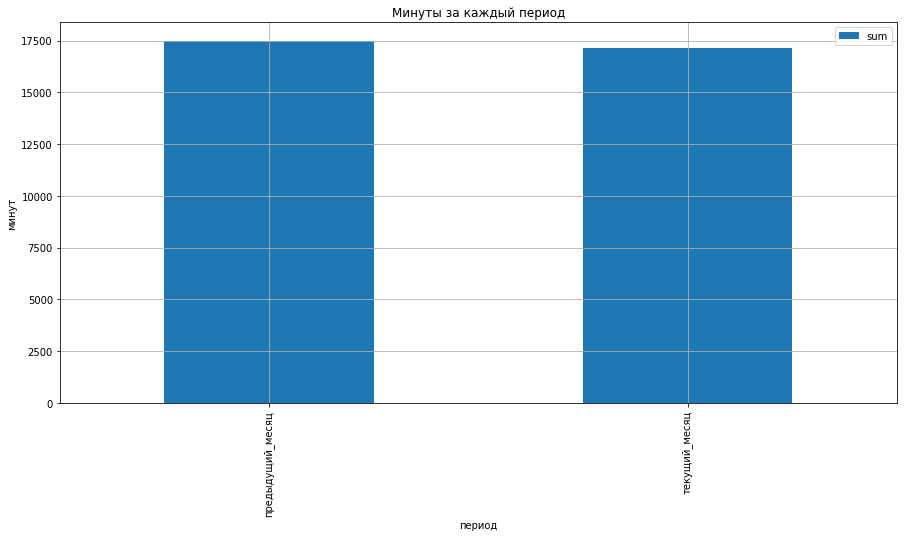

In [81]:
pivot_bar('Минуты за каждый период', 'минут', 'период', market_time_data, 'период', 'минут', ['sum'])

Пользователи проводят одинаковое количество времени за все периоды в данных.

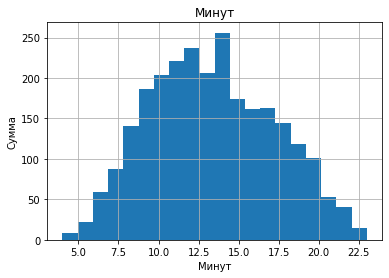

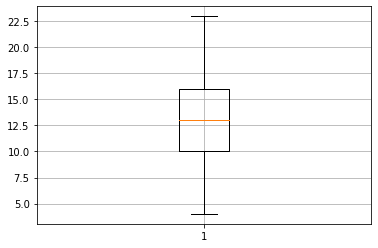

In [82]:
plt.hist(market_time_data['минут'], bins=20)
plt.grid(True)
plt.title('Минут')
plt.xlabel('Минут')
plt.ylabel('Сумма')
plt.show()

plt.boxplot(market_time_data['минут'])
plt.grid(True)

Количество минут имеет нормальное распределение и без выбросов.

**Далее проанализируем таблицу money_data:**

In [83]:
money_data.head(5)

,id,прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


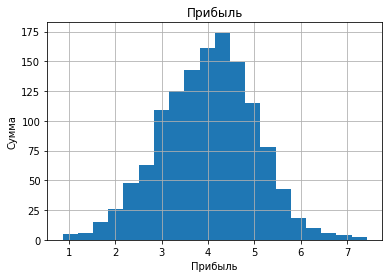

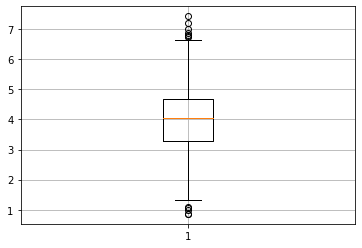

In [84]:
plt.hist(money_data['прибыль'], bins=20)
plt.grid(True)
plt.title('Прибыль')
plt.xlabel('Прибыль')
plt.ylabel('Сумма')
plt.show()

plt.boxplot(money_data['прибыль'])
plt.grid(True)

Природа выбросов ясна. Распределение нормальное.

**Клиенты с покупательской активностью не менее трёх месяцев:**

In [85]:
market_money_data.head(5)

,id,период,выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [86]:
market_file_data = market_file_data[~market_file_data['id'].isin(market_money_data.query('выручка == 0')['id'].to_list())]

In [87]:
market_time_data = market_time_data[~market_time_data['id'].isin(market_money_data.query('выручка == 0')['id'].to_list())]

In [88]:
money_data = money_data[~money_data['id'].isin(market_money_data.query('выручка == 0')['id'].to_list())]

In [89]:
market_money_data = market_money_data[~market_money_data['id'].isin(market_money_data.query('выручка == 0')['id'].to_list())]

Данные клиентов с покупательской активностью равной 0 были удалены из всех датасетов.

**Вывод:**
    
    - Исследованы все столбцы от категориальных до количественных.
    - Были выявлены выбросы и устранены, где это возможно.
    - В качестве меры устранения выбросов некоторых столбцов были выбраны выделение этих столбцов в категориальный.
    - Некоторые из категориальных столбцов имеют дисбаланс классов. Это следует учесть при работе с моделями.
    - Из всех таблиц были исключены пользователи, которые принесли 0 выручки за все 3 месяца.

## Объединение таблиц

In [163]:
market_file_data['id'].count()

1297

In [164]:
market_time_data['id'].count()

2594

In [165]:
market_time_data_to_df = market_time_data.set_index(['id', 'период'])['минут'].unstack().add_prefix('минут_')

In [166]:
market_time_data_to_df.count()

период
минут_предыдущий_месяц    1297
минут_текущий_месяц       1297
dtype: int64

In [167]:
df = market_file_data.merge(market_time_data_to_df, on='id')

In [168]:
df['id'].count()

1297

In [169]:
df.head(5)

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,маркет_актив_6_мес_оценка,акционные_покупки_оценка,неоплаченные_продукты_штук_квартал_оценка,минут_предыдущий_месяц,минут_текущий_месяц
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,средний,частые,нормальные,12,10
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,средний,редкие,низкие,8,13
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,средний,частые,низкие,11,13
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,средний,частые,низкие,8,11
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,средний,редкие,низкие,10,10


In [170]:
market_money_data['id'].count()

3890

In [171]:
df['id'].count()

1297

In [172]:
market_money_data_to_df = market_money_data.set_index(['id', 'период'])['выручка'].unstack().add_prefix('выручка_')

In [173]:
market_money_data_to_df.count()

период
выручка_предыдущий_месяц       1297
выручка_препредыдущий_месяц    1297
выручка_текущий_месяц          1296
dtype: int64

In [174]:
df = df.merge(market_money_data_to_df, on='id')

In [175]:
df['id'].count()

1297

In [176]:
df.head(5)

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,...,ошибка_сервиса,страниц_за_визит,маркет_актив_6_мес_оценка,акционные_покупки_оценка,неоплаченные_продукты_штук_квартал_оценка,минут_предыдущий_месяц,минут_текущий_месяц,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,...,2,5,средний,частые,нормальные,12,10,5216.0,4472.0,4971.6
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,...,1,5,средний,редкие,низкие,8,13,5457.5,4826.0,5058.4
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,...,6,4,средний,частые,низкие,11,13,6158.0,4793.0,6610.4
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,...,3,2,средний,частые,низкие,8,11,5807.5,4594.0,5872.5
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,...,1,4,средний,редкие,низкие,10,10,4738.5,5124.0,5388.5


In [177]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1297 entries, 0 to 1296
Data columns (total 21 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   id                                         1297 non-null   int64  
 1   покупательская_активность                  1297 non-null   object 
 2   тип_сервиса                                1297 non-null   object 
 3   разрешить_сообщать                         1297 non-null   object 
 4   маркет_актив_6_мес                         1297 non-null   float64
 5   маркет_актив_тек_мес                       1297 non-null   int64  
 6   длительность                               1297 non-null   int64  
 7   акционные_покупки                          1297 non-null   float64
 8   популярная_категория                       1297 non-null   object 
 9   средний_просмотр_категорий_за_визит        1297 non-null   int64  
 10  неоплаченные_продукты_шт

In [178]:
df[df['выручка_текущий_месяц'].isna()]

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,...,ошибка_сервиса,страниц_за_визит,маркет_актив_6_мес_оценка,акционные_покупки_оценка,неоплаченные_продукты_штук_квартал_оценка,минут_предыдущий_месяц,минут_текущий_месяц,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц
29,215380,Снизилась,премиум,нет,1.7,4,637,0.94,Техника для красоты и здоровья,3,...,4,7,низкий,частые,низкие,12,14,6077.0,5051.0,NaN


Так как нам нужны были покупатели с покупательской способностью не менее 3 месяцев, то вероятно, мы пропустили одно значение. Его следует удалить, так как по условиям задачи запись не релевантна.

In [179]:
df = df.drop(index=29)

In [180]:
df.duplicated().sum()

0

In [181]:
df = df.set_index('id')

**Проведем дополнительный исследовательский анализ по объединенной таблице:**

In [182]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 215349 to 216647
Data columns (total 20 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   покупательская_активность                  1296 non-null   object 
 1   тип_сервиса                                1296 non-null   object 
 2   разрешить_сообщать                         1296 non-null   object 
 3   маркет_актив_6_мес                         1296 non-null   float64
 4   маркет_актив_тек_мес                       1296 non-null   int64  
 5   длительность                               1296 non-null   int64  
 6   акционные_покупки                          1296 non-null   float64
 7   популярная_категория                       1296 non-null   object 
 8   средний_просмотр_категорий_за_визит        1296 non-null   int64  
 9   неоплаченные_продукты_штук_квартал         1296 non-null   int64  
 10  ошибка_сервиса   

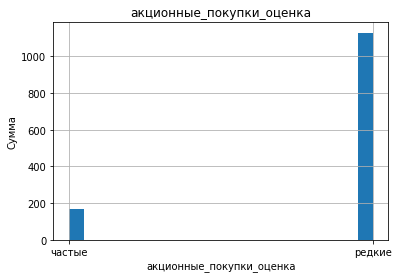

In [183]:
plt.hist(df['акционные_покупки_оценка'], bins=20)
plt.grid(True)
plt.title('акционные_покупки_оценка')
plt.xlabel('акционные_покупки_оценка')
plt.ylabel('Сумма')
plt.show()

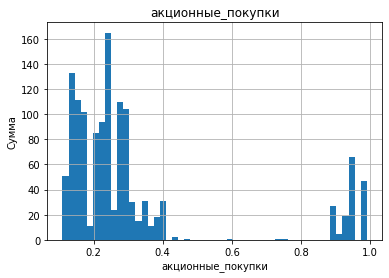

In [184]:
plt.hist(df['акционные_покупки'], bins=50)
plt.grid(True)
plt.title('акционные_покупки')
plt.xlabel('акционные_покупки')
plt.ylabel('Сумма')
plt.show()

_Оставим только один признак 'акционные покупки', чтобы избежать дальнейших проблем с моделью:_

In [185]:
df = df.drop(columns=['акционные_покупки_оценка'])

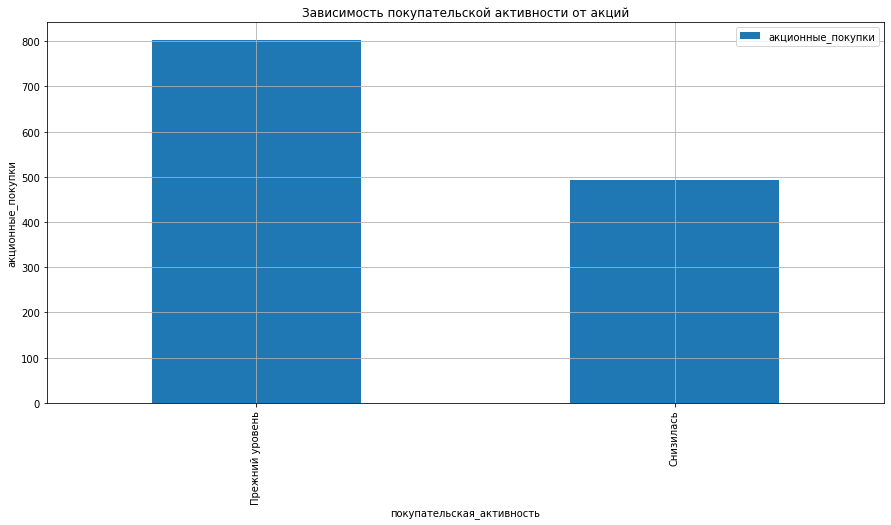

In [186]:
pivot_bar(
    'Зависимость покупательской активности от акций', 
    'акционные_покупки', 'покупательская_активность', 
    df, 
    'покупательская_активность', 'акционные_покупки', 
    ['count']
)

Как видно, чем больше акций, тем чаще покупатели остаются на прежнем уровне покупательсной активности. Вероятно, надо сделать упор на новые акции.

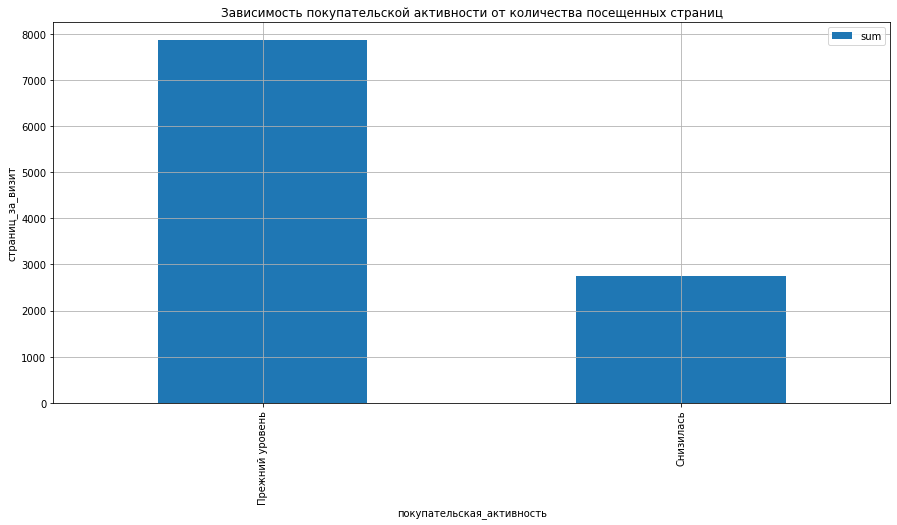

In [187]:
pivot_bar(
    'Зависимость покупательской активности от количества посещенных страниц',
    'страниц_за_визит', 'покупательская_активность', 
    df, 
    'покупательская_активность', 'страниц_за_визит', 
    ['sum']
)

Чем больше сумма посещенных страниц у пользователей, тем больше они покупают и остаются на прежнем уровне. Что и следовало ожидать.

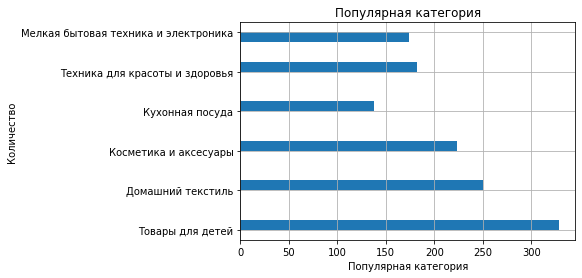

In [188]:
plt.hist(df['популярная_категория'], bins=20, orientation='horizontal')
plt.grid(True)
plt.title('Популярная категория')
plt.xlabel('Популярная категория')
plt.ylabel('Количество')
plt.show()

Чаще всего пользователи покупают товары для детей. Возможно, стоило бы сфокусироваться именно на этих товарах. Или же наоборот, если у магазина маленький выбор Кухонной посуды, то следует пополнить ассортимент, чтобы догнать по продажам остальные категории.

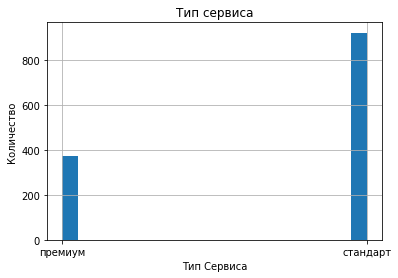

In [189]:
plt.hist(df['тип_сервиса'], bins=20)
plt.grid(True)
plt.title('Тип сервиса')
plt.xlabel('Тип Сервиса')
plt.ylabel('Количество')
plt.show()

Пользователи неохотно берут премиум подписку. Стоило бы пересмотреть условия премиума, чтобы пользователи охотнее покупали подписку.

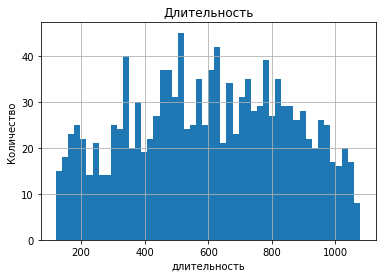

In [190]:
plt.hist(df['длительность'], bins=50)
plt.grid(True)
plt.title('Длительность')
plt.xlabel('длительность')
plt.ylabel('Количество')
plt.show()

Количество новых пользователей не слишком мало, что говорит о стабильном маркетинге в пользу потенциальных клиентов. Следует продолжать маркетинговую стратегию с дальнейшим улучшением по привличению новых клиентов.

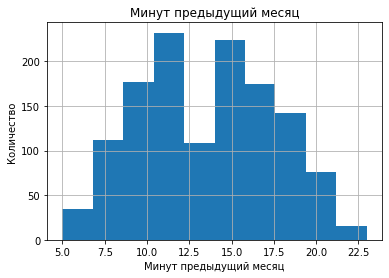

In [191]:
plt.hist(df['минут_предыдущий_месяц'], bins=10)
plt.grid(True)
plt.title('Минут предыдущий месяц')
plt.xlabel('Минут предыдущий месяц')
plt.ylabel('Количество')
plt.show()

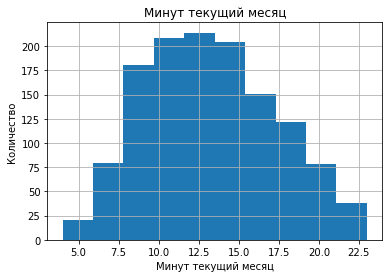

In [192]:
plt.hist(df['минут_текущий_месяц'], bins=10)
plt.grid(True)
plt.title('Минут текущий месяц')
plt.xlabel('Минут текущий месяц')
plt.ylabel('Количество')
plt.show()

Минуты текущего месяца распределены нормально, а вот в предыдущем месяце имеется яма в значениях 12.5-15.0. Возможно, связано со сбором данных. Тем не менее, покупатели проводят достаточно времени на сайте, чтобы купить товар.

**Вывод:**

    - В таблицах с выручкой и временем были выделены периоды отдельными столбцами.
    - Таблицы были объединены в одну.
    - Удален один пользователь, с покупательской способностью ниже 3х месяцев.
    - Также был проведен дополнительный анализ по объединенным таблицам.
    - Также был сразу удален признак акционные_покупки_оценка и оставлен изначальный, чтобы избежать проблем с моделью.

## Корреляционный анализ

In [193]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 215349 to 216647
Data columns (total 19 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   покупательская_активность                  1296 non-null   object 
 1   тип_сервиса                                1296 non-null   object 
 2   разрешить_сообщать                         1296 non-null   object 
 3   маркет_актив_6_мес                         1296 non-null   float64
 4   маркет_актив_тек_мес                       1296 non-null   int64  
 5   длительность                               1296 non-null   int64  
 6   акционные_покупки                          1296 non-null   float64
 7   популярная_категория                       1296 non-null   object 
 8   средний_просмотр_категорий_за_визит        1296 non-null   int64  
 9   неоплаченные_продукты_штук_квартал         1296 non-null   int64  
 10  ошибка_сервиса   

In [194]:
interval_cols = [
    'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 
    'акционные_покупки', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал',
    'ошибка_сервиса', 'страниц_за_визит', 'минут_предыдущий_месяц', 'минут_текущий_месяц',
    'выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц', 'выручка_текущий_месяц'
]
phik_matrix = df.phik_matrix(interval_cols=interval_cols)
phik_matrix.style.background_gradient(cmap="RdYlGn")

,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,маркет_актив_6_мес_оценка,неоплаченные_продукты_штук_квартал_оценка,минут_предыдущий_месяц,минут_текущий_месяц,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц
покупательская_активность,1.000000,0.129940,0.000000,0.544831,0.000000,0.099901,0.506276,0.299717,0.539607,0.505655,0.224154,0.749888,0.126178,0.231410,0.685138,0.576770,0.224638,0.497393,0.197213
тип_сервиса,0.129940,1.000000,0.289965,0.089911,0.045258,0.401411,0.030010,0.070809,0.185391,0.120027,0.079515,0.102594,0.022368,0.000000,0.131814,0.000000,0.000000,0.069704,0.124216
разрешить_сообщать,0.000000,0.289965,1.000000,0.000000,0.052618,0.253831,0.012198,0.073684,0.070359,0.195982,0.021839,0.042134,0.005773,0.072251,0.038387,0.000000,0.080842,0.000000,0.060907
маркет_актив_6_мес,0.544831,0.089911,0.000000,1.000000,0.079854,0.000000,0.279553,0.150386,0.206788,0.289421,0.142401,0.396769,1.000000,0.266190,0.363950,0.330601,0.155476,0.315331,0.039795
маркет_актив_тек_мес,0.000000,0.045258,0.052618,0.079854,1.000000,0.174233,0.000000,0.136243,0.246633,0.144203,0.116946,0.000000,0.110514,0.171722,0.107945,0.061410,0.051824,0.000000,0.000000
длительность,0.099901,0.401411,0.253831,0.000000,0.174233,1.000000,0.000000,0.000000,0.186795,0.192611,0.175608,0.122495,0.000000,0.123171,0.026448,0.101481,0.125572,0.113200,0.147048
акционные_покупки,0.506276,0.030010,0.012198,0.279553,0.000000,0.000000,1.000000,0.122385,0.199180,0.237962,0.000000,0.311418,0.405217,0.396949,0.262324,0.250558,0.060733,0.226381,0.071094
популярная_категория,0.299717,0.070809,0.073684,0.150386,0.136243,0.000000,0.122385,1.000000,0.226116,0.248620,0.000000,0.160300,0.028848,0.349888,0.195233,0.089883,0.252097,0.043528,0.237240
средний_просмотр_категорий_за_визит,0.539607,0.185391,0.070359,0.206788,0.246633,0.186795,0.199180,0.226116,1.000000,0.325578,0.070315,0.262271,0.277982,0.529921,0.159837,0.182568,0.098440,0.176828,0.092597
неоплаченные_продукты_штук_квартал,0.505655,0.120027,0.195982,0.289421,0.144203,0.192611,0.237962,0.248620,0.325578,1.000000,0.032907,0.363760,0.153082,1.000000,0.256632,0.232383,0.249171,0.261016,0.230022


**Шкала Чеддока:** 
 - слабая — от 0,1 до 0,3;
 - умеренная — от 0,3 до 0,5;
 - заметная — от 0,5 до 0,7;
 - высокая — от 0,7 до 0,9;
 - весьма высокая (сильная) — от 0,9 до 1,0

Покупательская активность - наш целевой признак. Руководствуясь шаклой Чеддока, можем увидеть отсутствие какой либо связи между признаками разрешить_сообщать, маркет_актив_тек_мес и целевым. Так же можем наблюдать, что имеем весьма высокую связь между исходными и созданными категориальными признаками. А именно - 'маркет_актив_6_мес' и 'маркет_актив_6_мес_оценка', 'неоплаченные_продукты_штук_квартал' и 'неоплаченные_продукты_штук_квартал_оценка'. Следует обратить внимание на эти признаки после shap анализа.

In [115]:
#df = df.drop(columns=['разрешить_сообщать', 'маркет_актив_тек_мес'], axis=1)

In [195]:
df = df.drop(columns=['маркет_актив_6_мес', 'неоплаченные_продукты_штук_квартал'], axis=1)

In [196]:
interval_cols = [
    'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 
    'акционные_покупки', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал',
    'ошибка_сервиса', 'страниц_за_визит', 'минут_предыдущий_месяц', 'минут_текущий_месяц',
    'выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц', 'выручка_текущий_месяц'
]
phik_matrix = df.phik_matrix(interval_cols=interval_cols)
phik_matrix.style.background_gradient(cmap="RdYlGn")

,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,ошибка_сервиса,страниц_за_визит,маркет_актив_6_мес_оценка,неоплаченные_продукты_штук_квартал_оценка,минут_предыдущий_месяц,минут_текущий_месяц,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц
покупательская_активность,1.000000,0.129940,0.000000,0.000000,0.099901,0.506276,0.299717,0.539607,0.224154,0.749888,0.126178,0.231410,0.685138,0.576770,0.224638,0.497393,0.197213
тип_сервиса,0.129940,1.000000,0.289965,0.045258,0.401411,0.030010,0.070809,0.185391,0.079515,0.102594,0.022368,0.000000,0.131814,0.000000,0.000000,0.069704,0.124216
разрешить_сообщать,0.000000,0.289965,1.000000,0.052618,0.253831,0.012198,0.073684,0.070359,0.021839,0.042134,0.005773,0.072251,0.038387,0.000000,0.080842,0.000000,0.060907
маркет_актив_тек_мес,0.000000,0.045258,0.052618,1.000000,0.174233,0.000000,0.136243,0.246633,0.116946,0.000000,0.110514,0.171722,0.107945,0.061410,0.051824,0.000000,0.000000
длительность,0.099901,0.401411,0.253831,0.174233,1.000000,0.000000,0.000000,0.186795,0.175608,0.122495,0.000000,0.123171,0.026448,0.101481,0.125572,0.113200,0.147048
акционные_покупки,0.506276,0.030010,0.012198,0.000000,0.000000,1.000000,0.122385,0.199180,0.000000,0.311418,0.405217,0.396949,0.262324,0.250558,0.060733,0.226381,0.071094
популярная_категория,0.299717,0.070809,0.073684,0.136243,0.000000,0.122385,1.000000,0.226116,0.000000,0.160300,0.028848,0.349888,0.195233,0.089883,0.252097,0.043528,0.237240
средний_просмотр_категорий_за_визит,0.539607,0.185391,0.070359,0.246633,0.186795,0.199180,0.226116,1.000000,0.070315,0.262271,0.277982,0.529921,0.159837,0.182568,0.098440,0.176828,0.092597
ошибка_сервиса,0.224154,0.079515,0.021839,0.116946,0.175608,0.000000,0.000000,0.070315,1.000000,0.183682,0.000000,0.145201,0.243978,0.177180,0.000000,0.138558,0.000000
страниц_за_визит,0.749888,0.102594,0.042134,0.000000,0.122495,0.311418,0.160300,0.262271,0.183682,1.000000,0.239678,0.377450,0.478889,0.382377,0.148410,0.339954,0.139891


**Вывод:**

    - Был проведен корреляционный анализ и выявлены признаки не имеющие связи с целевым. А именно поля 'разрешить_сообщать', 'маркет_актив_тек_мес'. В случае плохих показателей моделей - необходимо вернуться к анализу и убрать эти признаки.
    - Риск мультиколлинеарности не был обнаружен, так как по шкале Чеддока не было весьма высоких связей.
    - Тем не менее есть высокая связь между 'страниц_за_визит' и целевым признаком, а также 'выручка_текущий_месяц' и 'выручка_предыдущий месяц'. В случае плохих показателей моделей - необходимо вернуться к анализу и убрать эти признаки.
    - Так же было обнаружено, что имеется весьма высокая связь между исходными и созданными категориальными признаками. А именно - 'маркет_актив_6_мес' и 'маркет_актив_6_мес_оценка', 'неоплаченные_продукты_штук_квартал' и 'неоплаченные_продукты_штук_квартал_оценка'. В случае плохих показателей моделей - необходимо вернуться к анализу и убрать эти признаки.
    - Признаки 'маркет_актив_6_мес', 'неоплаченные_продукты_штук_квартал' были удалены, так как имеют аналог в виде оценки.

## Использование пайплайнов

In [222]:
df.head(5)

,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,ошибка_сервиса,страниц_за_визит,маркет_актив_6_мес_оценка,неоплаченные_продукты_штук_квартал_оценка,минут_предыдущий_месяц,минут_текущий_месяц,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц
id,,,,,,,,,,,,,,,,,
215349,Снизилась,премиум,да,4,819,0.75,Товары для детей,4,2,5,средний,нормальные,12,10,5216.0,4472.0,4971.6
215350,Снизилась,стандарт,нет,3,539,0.14,Домашний текстиль,5,1,5,средний,низкие,8,13,5457.5,4826.0,5058.4
215351,Снизилась,стандарт,да,5,896,0.99,Товары для детей,5,6,4,средний,низкие,11,13,6158.0,4793.0,6610.4
215352,Снизилась,стандарт,нет,3,1064,0.94,Товары для детей,3,3,2,средний,низкие,8,11,5807.5,4594.0,5872.5
215353,Снизилась,стандарт,да,4,762,0.26,Домашний текстиль,4,1,4,средний,низкие,10,10,4738.5,5124.0,5388.5


In [223]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 215349 to 216647
Data columns (total 17 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   покупательская_активность                  1296 non-null   object 
 1   тип_сервиса                                1296 non-null   object 
 2   разрешить_сообщать                         1296 non-null   object 
 3   маркет_актив_тек_мес                       1296 non-null   int64  
 4   длительность                               1296 non-null   int64  
 5   акционные_покупки                          1296 non-null   float64
 6   популярная_категория                       1296 non-null   object 
 7   средний_просмотр_категорий_за_визит        1296 non-null   int64  
 8   ошибка_сервиса                             1296 non-null   int64  
 9   страниц_за_визит                           1296 non-null   int64  
 10  маркет_актив_6_ме

In [224]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [225]:
X = df.drop(columns='покупательская_активность', axis=1)
y = df['покупательская_активность']

In [240]:
ohe_columns = ['разрешить_сообщать', 'тип_сервиса', 'популярная_категория']

ord_columns = ['маркет_актив_6_мес_оценка', 'неоплаченные_продукты_штук_квартал_оценка']

num_columns = [
    'маркет_актив_тек_мес', 'длительность', 'акционные_покупки', 
    'средний_просмотр_категорий_за_визит', 'ошибка_сервиса', 
    'страниц_за_визит', 'минут_предыдущий_месяц', 'минут_текущий_месяц', 
    'выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц', 'выручка_текущий_месяц'
]

In [241]:
for column in ord_columns:
    print("'"+column+"'"+':','[' + ", ".join(str("'"+x+"'") for x in df[column].unique()) + ']')

'маркет_актив_6_мес_оценка': ['средний', 'низкий', 'высокий']
'неоплаченные_продукты_штук_квартал_оценка': ['нормальные', 'низкие', 'высокий']


In [242]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = y
)

In [243]:
label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [244]:
ohe_pipe = Pipeline([
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False))
])

In [245]:
ord_pipe = Pipeline([
    ('ord',  OrdinalEncoder(
        categories=[
            ['средний', 'низкий', 'высокий'],
            ['нормальные', 'низкие', 'высокий'],
        ], 
        handle_unknown='use_encoded_value', unknown_value=np.nan
    )),
    ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
])


In [246]:
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [247]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [255]:
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,5),
        'models__max_features': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']   
    },
    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
    # словарь для модели SVC()
    {
        'models': [SVC(probability=True)],
        'models__degree': range(1,5),
        'models__C': range(1,5),
        'models__kernel': ['rbf','sigmoid', 'linear'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    }
]

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

randomized_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse=False))]),
                                                                               ['разрешить_сообщать',
                                                                                'тип_сервиса',
                                                                                'популярная_категория']),
                                                                              ('ord',
                                                                               Pipeline(steps=[('ord',
                                                                                                OrdinalEncoder(categories=[['средний',
                                                                                                                            '...
                                         'models__C': range(1, 5),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               RobustScaler(),
                                                               'passthrough']},
                                        {'models': [SVC(C=3, probability=True)],
                                         'models__C': range(1, 5),
                                         'models__degree': range(1, 5),
                                         'models__kernel': ['rbf', 'sigmoid',
                                                            'linear'],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               RobustScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc')

In [256]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на валидационной выборке:', round(randomized_search.best_score_, 2))

y_test_pred = randomized_search.predict_proba(X_test)[:,1]
print(f'Метрика ROC-AUC на тестовой выборке: {round(roc_auc_score(y_test, y_test_pred), 2)}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['разрешить_сообщать',
                                                   'тип_сервиса',
                                                   'популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('ord',
                                                                   OrdinalEncoder(categories=[['с

**Вывод:**

    - Для оценки была выбрана метрика roc_auc потому что она показывает наиболее точную характеристику TPR и FPR. Так как нам нужно оценить качество предсказаний снижения покупательской активности, то метрика подойдет.
    - Для выбора лучшей модели использовали RandomizedSearchCV, для экономии ресурсов и скорости работы.
    - Для масштабирования и преобразования категориальных признаков использовались все доступные, на данном этапе, наборы инструментов.
    - Лучший показатель roc_auc у модели SVC(C=3). На тренировочных данных имеет roc_auc = 0.89, на тестовый = 0.92.

## Анализ важности признаков

In [257]:
best_model = randomized_search.best_estimator_.named_steps['models']

In [258]:
preprocessor = randomized_search.best_estimator_.named_steps['preprocessor']

In [259]:
X_test_p = preprocessor.transform(X_test)

In [260]:
X_test_p.shape

(324, 20)

In [261]:
background = shap.sample(X_test_p, 50)
explainer = shap.KernelExplainer(best_model.predict, background)
shap_values = explainer(background)

  0%|          | 0/50 [00:00<?, ?it/s]

In [262]:
i = 0
for feature_name in preprocessor.get_feature_names_out():
    print('Feature '+str(i)+':', feature_name)
    i+=1

Feature 0: ohe__разрешить_сообщать_нет
Feature 1: ohe__тип_сервиса_стандарт
Feature 2: ohe__популярная_категория_Косметика и аксесуары
Feature 3: ohe__популярная_категория_Кухонная посуда
Feature 4: ohe__популярная_категория_Мелкая бытовая техника и электроника
Feature 5: ohe__популярная_категория_Техника для красоты и здоровья
Feature 6: ohe__популярная_категория_Товары для детей
Feature 7: ord__маркет_актив_6_мес_оценка
Feature 8: ord__неоплаченные_продукты_штук_квартал_оценка
Feature 9: num__маркет_актив_тек_мес
Feature 10: num__длительность
Feature 11: num__акционные_покупки
Feature 12: num__средний_просмотр_категорий_за_визит
Feature 13: num__ошибка_сервиса
Feature 14: num__страниц_за_визит
Feature 15: num__минут_предыдущий_месяц
Feature 16: num__минут_текущий_месяц
Feature 17: num__выручка_предыдущий_месяц
Feature 18: num__выручка_препредыдущий_месяц
Feature 19: num__выручка_текущий_месяц


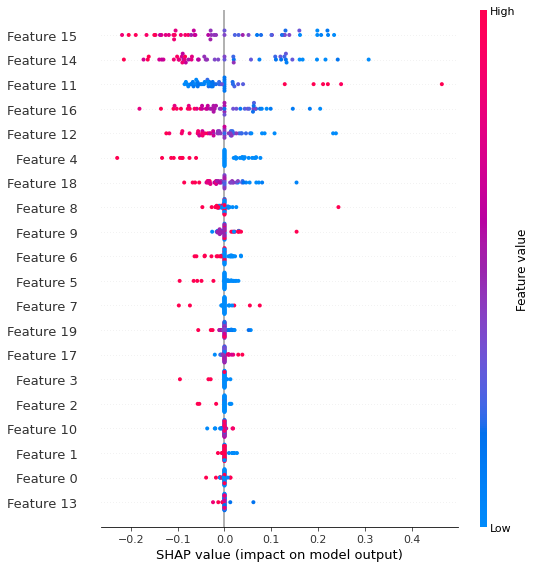

In [263]:
shap.plots.beeswarm(shap_values, max_display=32)

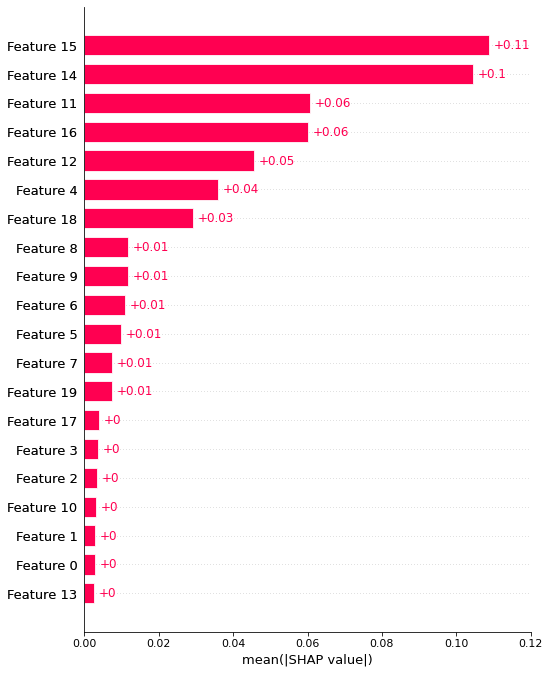

In [265]:
shap.plots.bar(shap_values, max_display=32)

**Вывод:**

    - Признаки num__выручка_предыдущий_месяц и ohe__популярная_категория_Кухонная посуда, ohe__популярная_категория_Косметика и аксесуары, num__длительность, ohe__тип_сервиса_стандарт, ohe__разрешить_сообщать_нет, num__ошибка_сервиса не задействуются в модели.
    - Также малое влияние оказывают значения num__выручка_текущий_месяц, num__выручка_предыдущий_месяц, ohe__тип_сервиса_стандарт, ord__маркет_актив_6_мес_оценка, num__выручка_текущий_месяц, num__маркет_актив_тек_мес, ohe__популярная_категория_Товары для детей, ohe__популярная_категория_Техника для красоты и здоровья, ord__маркет_актив_6_мес_оценка, num__выручка_текущий_месяц.
    - Самое большое влияние у признаков num__минут_предыдущий_месяц, num__страниц_за_визит, num__акционные_покупки.
    - На основе этих признаков, можно сместить фокус маркетинга на пользователей, среднее посещение страниц которых является наименьшим, чтобы предложить им больше товаров. Или тех, кто проводит определенное количество минут на сайте за предыдущий текущий месяц, для формирования предложений на следующий месяц(рекомендательная система).
    - Можно сместить фокус на формирование акций для покупок и товары бытовой техники, так как эти признаки наиболее востребованы.

## Сегментация покупателей

In [361]:
dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))

{'Прежний уровень': 0, 'Снизилась': 1}

In [362]:
results = pd.DataFrame({'активность': y_test}, index=X_test.index)

In [363]:
results['активность'] = results['активность'].apply(lambda x: 'Прежний уровень' if x == 0 else 'Снизилась')

In [364]:
segment_data = results.merge(money_data, on='id')

In [365]:
segment_data.head(5)

,id,активность,прибыль
0,216161,Прежний уровень,4.69
1,215654,Снизилась,2.75
2,216307,Прежний уровень,3.16
3,215501,Снизилась,3.74
4,215934,Снизилась,4.40


In [366]:
segment_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 324 entries, 0 to 323
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          324 non-null    int64  
 1   активность  324 non-null    object 
 2   прибыль     324 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 10.1+ KB


In [367]:
segment_data = segment_data.merge(X_test, on='id')

In [368]:
segment_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 324 entries, 0 to 323
Data columns (total 19 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   id                                         324 non-null    int64  
 1   активность                                 324 non-null    object 
 2   прибыль                                    324 non-null    float64
 3   тип_сервиса                                324 non-null    object 
 4   разрешить_сообщать                         324 non-null    object 
 5   маркет_актив_тек_мес                       324 non-null    int64  
 6   длительность                               324 non-null    int64  
 7   акционные_покупки                          324 non-null    float64
 8   популярная_категория                       324 non-null    object 
 9   средний_просмотр_категорий_за_визит        324 non-null    int64  
 10  ошибка_сервиса            

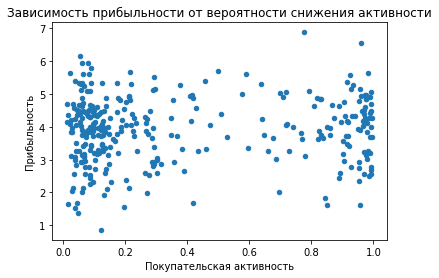

In [369]:
probas = randomized_search.predict_proba(
    segment_data.drop(
        ['прибыль', 'id', 'активность'], axis=1
    )
)[:,1]

segment_data['вероятность_снижения_активности'] = probas

segment_data.plot.scatter(
    x='вероятность_снижения_активности',
    y='прибыль',
    title='Зависимость прибыльности от вероятности снижения активности',
    xlabel='Покупательская активность',
    ylabel='Прибыльность'
)

plt.show()

In [373]:
segment_data = segment_data[(segment_data['вероятность_снижения_активности'] >= 0.6) & (segment_data['прибыль'] >= 3)]

In [392]:
segment_data['id'].count()

85

**Разберем пользователей у которых, на основе результатов моделирования, прогноз снижения покупательской активности наиболее вероятен и проанализируем:**

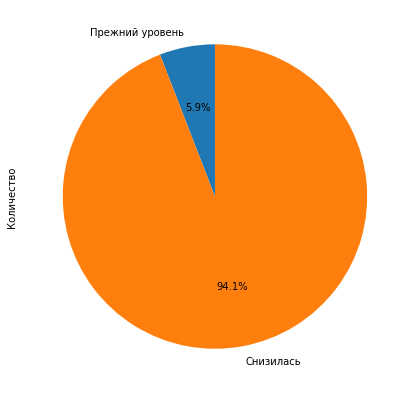

In [375]:
pivot_pie('активность', segment_data, 'активность', 'id', ['count'])

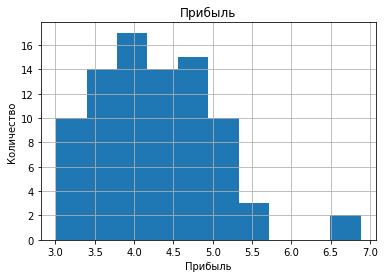

In [379]:
plt.hist(segment_data['прибыль'], bins=10)
plt.grid(True)
plt.title('Прибыль')
plt.xlabel('Прибыль')
plt.ylabel('Количество')
plt.show()

**Посмотрим распределение по категориям:**

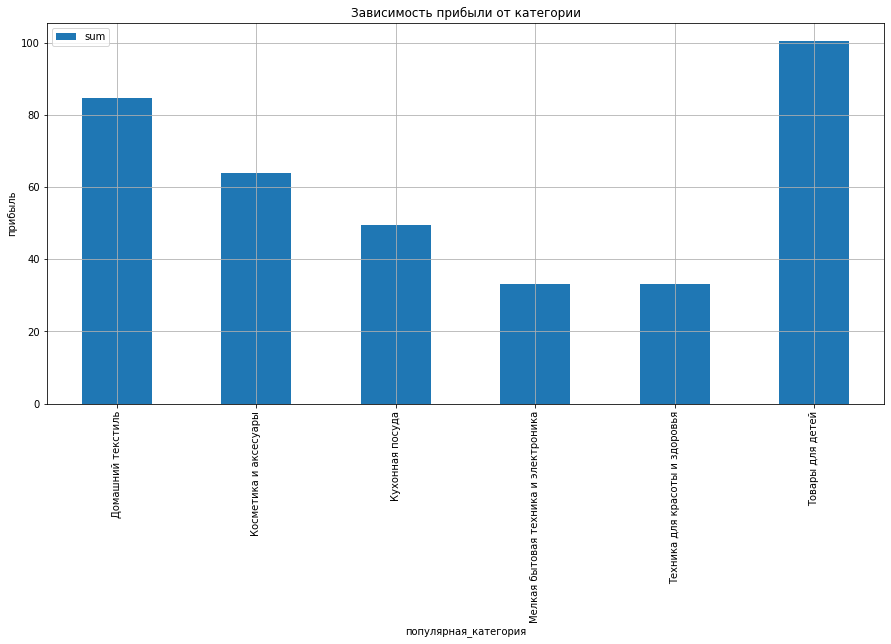

In [381]:
pivot_bar('Зависимость прибыли от категории', 'прибыль', 'популярная_категория', segment_data, 'популярная_категория', 'прибыль', ['sum'])

Товары для детей принесли больше всего прибыли у премиум пользователей. Меньше всего - Мелкая бытовая техника и электроника. Возможно стоит сделать фокус именно на категорию Мелкая бытовая техника и электроника.

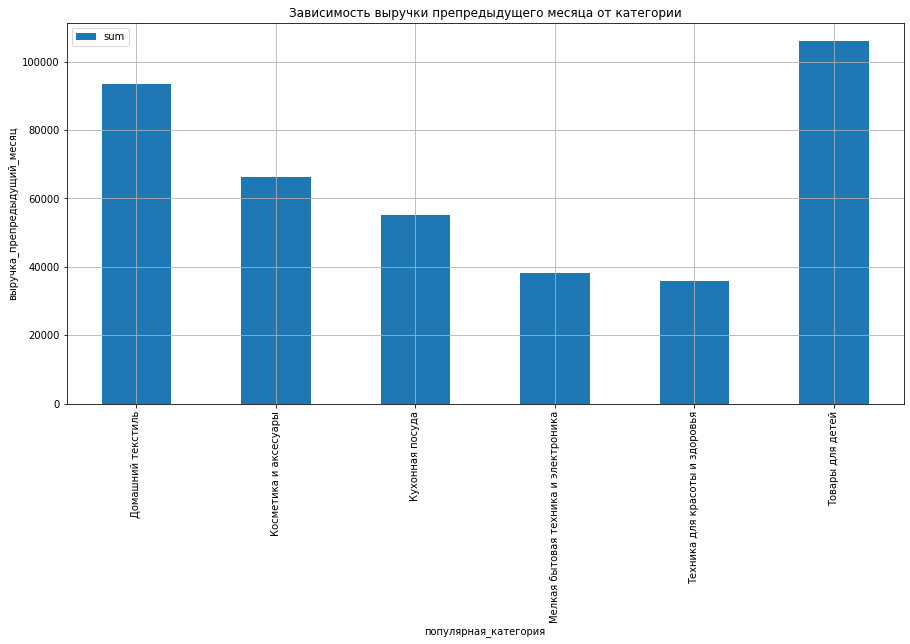

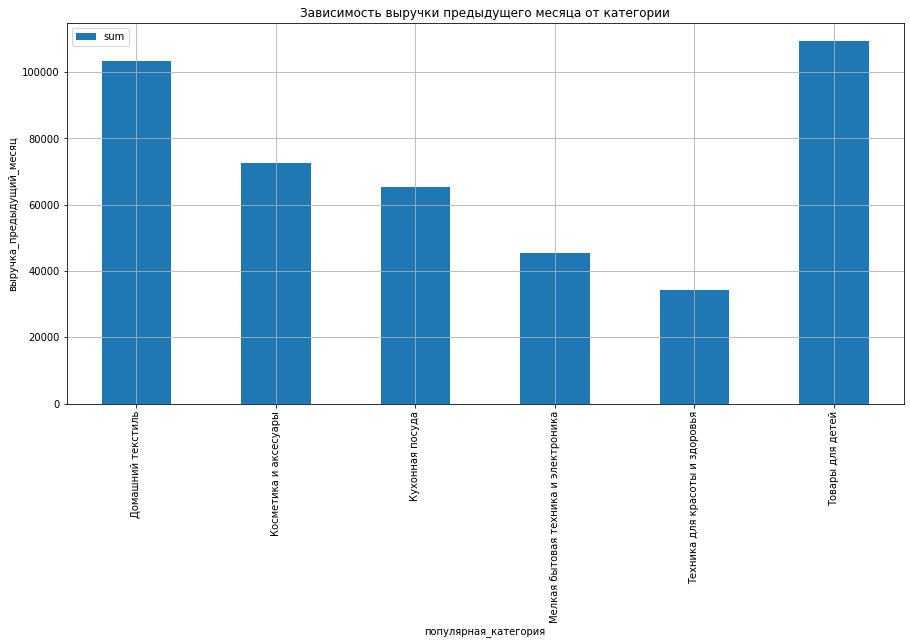

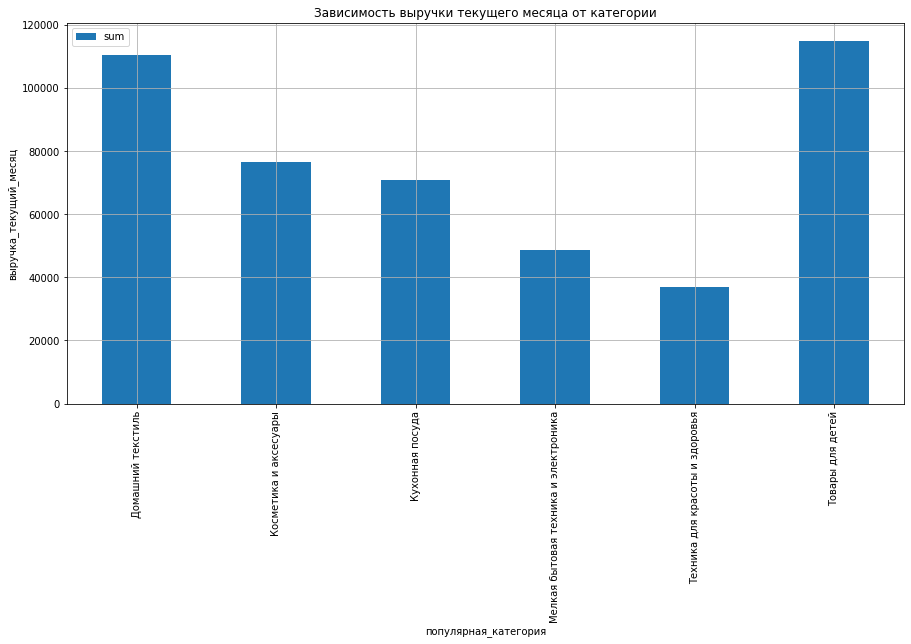

In [382]:
pivot_bar('Зависимость выручки препредыдущего месяца от категории', 'выручка_препредыдущий_месяц', 'популярная_категория', segment_data, 'популярная_категория', 'выручка_препредыдущий_месяц', ['sum'])
pivot_bar('Зависимость выручки предыдущего месяца от категории', 'выручка_предыдущий_месяц', 'популярная_категория', segment_data, 'популярная_категория', 'выручка_предыдущий_месяц', ['sum'])
pivot_bar('Зависимость выручки текущего месяца от категории', 'выручка_текущий_месяц', 'популярная_категория', segment_data, 'популярная_категория', 'выручка_текущий_месяц', ['sum'])

По периодам выручки можно заметить, что самая недвижимая категория - Техника для красоты и здоровья. Вероятно, следует сделать упор на разнообразие этой категории или больше маркетинга в ее сторону.

**Посмотрим как сегмент проявляет активность на сайте:**

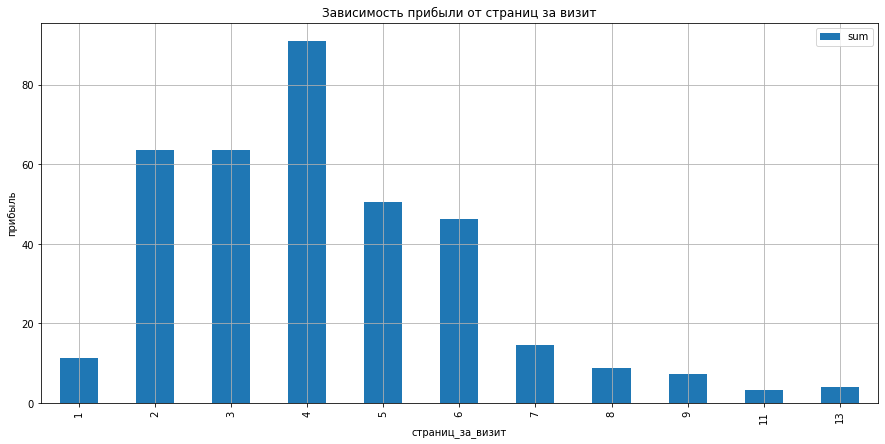

In [383]:
pivot_bar('Зависимость прибыли от страниц за визит', 'прибыль', 'страниц_за_визит', segment_data, 'страниц_за_визит', 'прибыль', ['sum'])

Пользователи не задерживаются на сайте. Вероятно, следует применить некоторые способы удержания внимания на сайте, чтобы пользователь обратил внимание на то, что ему нужно. Или улучшить систему рекомендаций, чтобы пользователь активнее переходил по нужным ему товарам.

**Далее посмотрим как сегмент реагирует на акции:**

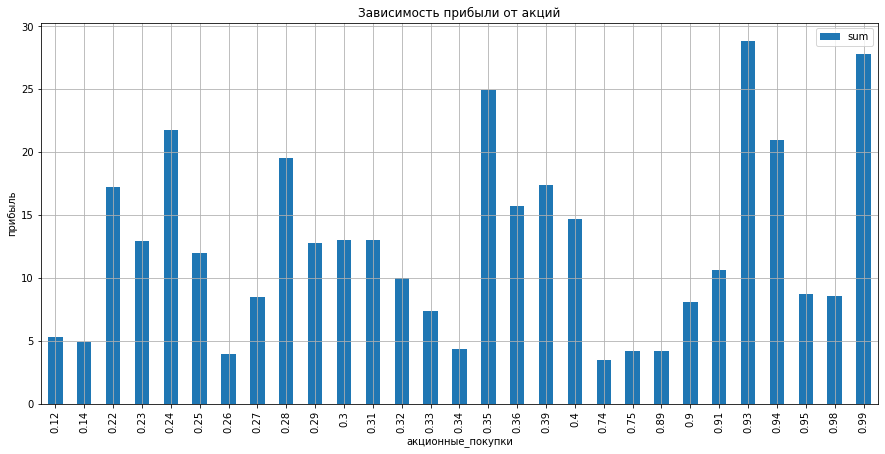

In [384]:
pivot_bar('Зависимость прибыли от акций', 'прибыль', 'акционные_покупки', segment_data, 'акционные_покупки', 'прибыль', ['sum'])

Очевидно, чем больше акций - тем больше акционных покупок. Следует сфокусироваться на хороших акциях для пользователей, без потери прибыли.

**Посмотрим как часто пользователи оставляют товары в корзине и не оплачивают:**

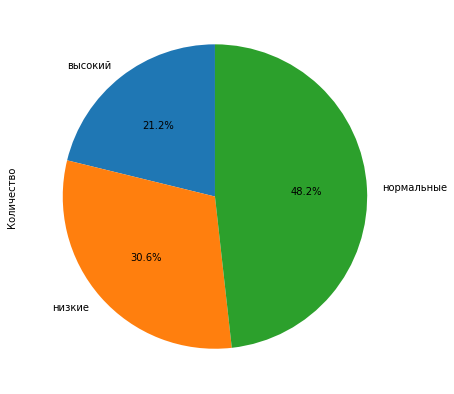

In [385]:
pivot_pie('неоплаченные_продукты_штук_квартал_оценка', segment_data, 'неоплаченные_продукты_штук_квартал_оценка', 'id', ['count'])

Пользователи пришли за скидками и мы видим, что довольно часто они кладут товар в корзину и не оплачивают его(21.2%). Вероятно они ожидают скидку и кладут товар для будущей покупки.

**Посмотрим зависимость прибыли от минут проведенных на сайте за прошлый и текущий месяц:**

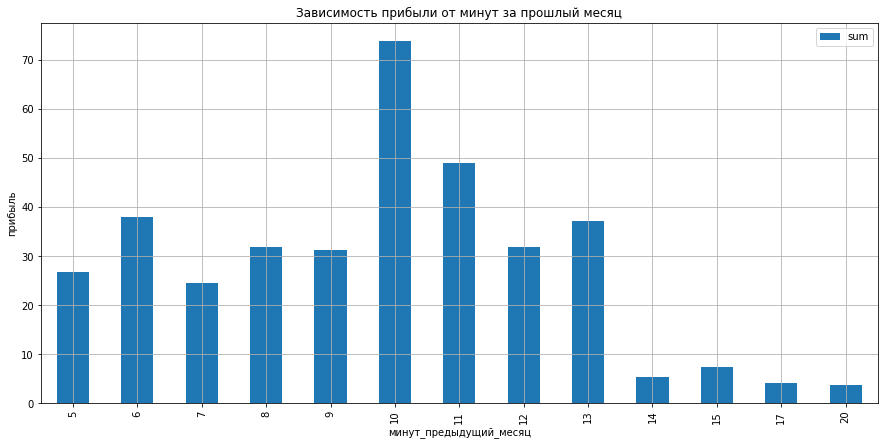

In [388]:
pivot_bar('Зависимость прибыли от минут за прошлый месяц', 'прибыль', 'минут_предыдущий_месяц', segment_data, 'минут_предыдущий_месяц', 'прибыль', ['sum'])

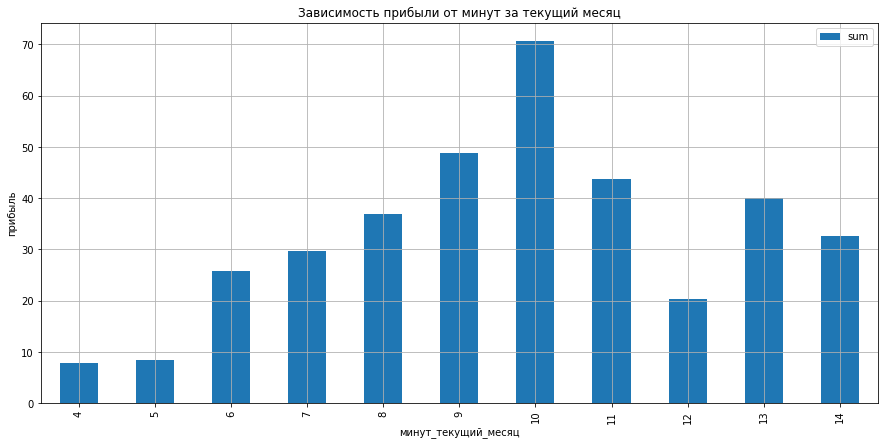

In [389]:
pivot_bar('Зависимость прибыли от минут за текущий месяц', 'прибыль', 'минут_текущий_месяц', segment_data, 'минут_текущий_месяц', 'прибыль', ['sum'])

Пользователи стали больше времени проводить в текущем месяце, чем в предыдущем - это хорошая тенденция, следует поддерживать фокус на рекомендациях, чтобы покупатель остался в хорошем расположении и купил больше товаров.

**Посмотрим как давно пользователи зарегистрировались на сайте:**

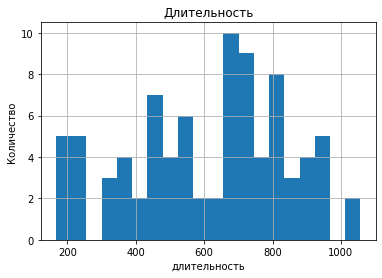

In [391]:
plt.hist(segment_data['длительность'], bins=20)
plt.grid(True)
plt.title('Длительность')
plt.xlabel('длительность')
plt.ylabel('Количество')
plt.show()

Новички проявляют меньшую покупательскую активность, что логично, они еще присматриваются и следует сфокусироваться на удержании их внимания. Хуже всего - "старички" теряют покупательскую активность. Вероятно следует проработать новые условия премиум подписки или же разработать улучшенную стратегию акций и скидок.

**Вывод:**
    
    - Для дополнительного исследования был взять сегмент на основе прогноза снижения покупательской активности.
    - Товары для детей принесли больше всего прибыли у премиум пользователей. Меньше всего - Мелкая бытовая техника и электроника. Возможно стоит сделать фокус на категорию Мелкая бытовая техника и электроника
    - По периодам выручки можно заметить, что самая недвижимая категория - Техника для красоты и здоровья. Вероятно, следует сделать упор на разнообразие этой категории, в равной степени с категорией Мелкая бытовая техника и электроника.
    - Также рекомендую применить способы удержания внимания на сайте, чтобы пользователь обратил внимание на то, что ему нужно. Или улучшить систему рекомендаций, чтобы пользователь активнее переходил по нужным ему товарам.
    - Очевидно, чем больше акций - тем больше акционных покупок. Следует проработать новые условия премиум подписки или же разработать улучшенную стратегию акций и скидок.

## Общий вывод

**Описание задачи:**

    Промаркировать уровень финансовой активности постоянных покупателей. В компании принято выделять два уровня активности: «снизилась», если клиент стал покупать меньше товаров, и «прежний уровень».

    Собрать данные по клиентам по следующим группам:

    - Признаки, которые описывают коммуникацию сотрудников компании с клиентом.
    - Признаки, которые описывают продуктовое поведение покупателя. Например, какие товары покупает и как часто.
    - Признаки, которые описывают покупательское поведение клиента. Например, сколько тратил в магазине.
    - Признаки, которые описывают поведение покупателя на сайте. Например, как много страниц просматривает и сколько времени проводит на сайте.

1. Построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.
2. В исследование нужно включить дополнительные данные финансового департамента о прибыльности клиента: какой доход каждый покупатель приносил компании за последние три месяца.
3. Используя данные модели и данные о прибыльности клиентов, нужно выделить сегменты покупателей и разработать для них персонализированные предложения.

**Исходные данные и предобработка:**

    - Были выгружены данные из четырех разных файлов в четыре переменные. Все данные соответствуют описанию.
    - В таблице market_file_data 1300 записи с колонками, совпадающими с описанием.
    - В таблице market_money_data 3900 записи с колонками идентификатора, Период и Выручка.
    - В таблице market_time_data 2600 записей с колонками id, Период, минут.
    - В таблице money_data 1300 записей с колонками id и Прибыль.
    
    - Поля были нормализованы к snake case и к нижнему регистру.
    - Удалены неявные дубликаты 'стандарт' из таблицы market_file_data поля 'тип_сервиса'.
    - Переименованы значения в таблице market_time_data, поля 'период' с 'предыдцщий_месяц', на 'предыдущий_месяц'. Острой необходимости не было, но так лучше читается.
    - Также были преобразованы колонки 'маркет_актив_6_мес', 'акционные_покупки' таблицы market_file_data из типа object в float64.
    
**Поиск лучшей модели:**

    - Для поиска лучшей модели был проведен корреляционный анализ и выявлены признаки не имеющие связи с целевым. А именно поля 'разрешить_сообщать', 'маркет_актив_тек_мес' были удалены.
    - Риск мультиколлинеарности не был обнаружен, так как по шкале Чеддока не было весьма высоких связей.
    - Тем не менее есть высокая связь между 'страниц_за_визит' и целевым признаком, а также 'выручка_текущий_месяц' и 'выручка_предыдущий месяц'. В случае плохих показателей моделей - необходимо вернуться к анализу и убрать эти признаки.
    - Так же было обнаружено, что имеется весьма высокая связь между исходными и созданными категориальными признаками. А именно - 'маркет_актив_6_мес' и 'маркет_актив_6_мес_оценка', 'акционные_покупки' и 'акционные_покупки_оценка', 'неоплаченные_продукты_штук_квартал' и 'неоплаченные_продукты_штук_квартал_оценка'. Оставили те, которые имеют меньшую связь с целевым признаком, чтобы потенциально улучшить прогнозы моделей.
    
    - Так же был сформирован пайплайн для выбора лучшей модели и ее гиперпараметров. 
    - Для оценки была выбрана метрика roc_auc потому что она показывает наиболее точную характеристику TPR и FPR. Так как нам нужно оценить качество предсказаний снижения покупательской активности, то метрика подойдет.
    - Для выбора лучшей модели использовали RandomizedSearchCV, для экономии ресурсов и скорости работы.
    - Для масштабирования и преобразования категориальных признаков использовались все доступные, на данном этапе, наборы инструментов.
    - Лучший показатель roc_auc у модели SVC(C=3). На тренировочных данных имеет roc_auc = 0.89, на тестовый = 0.88.
    
    - Также был проведен анализ важности признаков по итогу его выяснилось, что признаки num__ошибка_сервиса и ohe__популярная_категория_Косметика и аксесуары практически не задействуются в модели.
    - Также малое влияние оказывают значения ord__неоплаченные_продукты_штук_квартал_оценка, num__выручка_предыдущий_месяц, ohe__тип_сервиса_стандарт, ord__маркет_актив_6_мес_оценка, num__выручка_текущий_месяц, ohe__популярная_категория_Техника для красоты и здоровья, num__длительность, ohe__популярная_категория_Кухонная посуда.
    - Самое большое влияние у признаков num__минут_предыдущий_месяц, num__страниц_за_визит, num__минут_текущий_месяц.
    - На основе этих признаков, можно сместить фокус маркетинга на пользователей, среднее посещение страниц которых является наименьшим, чтобы предложить им больше товаров. Или тех, кто проводит определенное количество минут на сайте за предыдущий текущий месяц, для формирования предложений на следующий месяц(рекомендательная система).
    - Можно сместить фокус на формирование акций для покупок и товары бытовой техники, так как эти признаки наиболее востребованы.
    
**Выводы и дополнительные предложения по сегменту пользователей, у которых высокий прогноз снижения покупательской активности:**

    - Для дополнительного исследования был взять сегмент на основе прогноза снижения покупательской активности.
    - Товары для детей принесли больше всего прибыли у премиум пользователей. Меньше всего - Мелкая бытовая техника и электроника. Возможно стоит сделать фокус на категорию Мелкая бытовая техника и электроника
    - По периодам выручки можно заметить, что самая недвижимая категория - Техника для красоты и здоровья. Вероятно, следует сделать упор на разнообразие этой категории, в равной степени с категорией Мелкая бытовая техника и электроника.
    - Также рекомендую применить способы удержания внимания на сайте, чтобы пользователь обратил внимание на то, что ему нужно. Или улучшить систему рекомендаций, чтобы пользователь активнее переходил по нужным ему товарам.
    - Очевидно, чем больше акций - тем больше акционных покупок. Следует проработать новые условия премиум подписки или же разработать улучшенную стратегию акций и скидок.